In [ ]:
import sys
sys.path.append('../')

In [34]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt

In [283]:
def calc_strategy_returns_stats(backtest_series, excess_return_series, target_vol=None, target_return=0.08):
    """Evaluate returns of a trading strategy."""

    # construct backtest dataframe
    backtest_series = backtest_series.rename('Strategy_Returns')
    excess_return_series = excess_return_series.rename('Strategy_Excess_Returns')
    backtest_series = pd.concat([backtest_series, excess_return_series], axis=1)
    backtest_series.dropna(inplace=True)
    num_data_per_year = backtest_series.Strategy_Returns.resample('Y').count().mode().values[-1]
    num_data_total = backtest_series.shape[0]
    if target_vol is not None:
        vol_scaling = target_vol / (np.std(backtest_series['Strategy_Returns']) * np.sqrt(num_data_per_year))
        backtest_series['Strategy_Returns'] = vol_scaling * backtest_series['Strategy_Returns']
        backtest_series['Strategy_Excess_Returns'] = vol_scaling * backtest_series['Strategy_Excess_Returns']

    # basic return stats
    mean_ret_annual = ((1 + backtest_series['Strategy_Returns']).prod()) ** (num_data_per_year / num_data_total) - 1
    mean_exc_ret_annual = ((1 + backtest_series['Strategy_Excess_Returns']).prod()) ** (
            num_data_per_year / num_data_total) - 1
    vola_annual = np.std(backtest_series['Strategy_Returns']) * np.sqrt(num_data_per_year)
    sharpe = mean_exc_ret_annual / vola_annual
    rescaled_target_return = (1 + target_return) ** (1 / num_data_per_year) - 1
    diff_target_return = backtest_series['Strategy_Returns'] - rescaled_target_return
    mean_diff_target_return = ((1 + diff_target_return).prod() ** (num_data_per_year / num_data_total)) - 1
    diff_target_return[diff_target_return > 0] = 0
    target_downside_deviation = diff_target_return.std() * np.sqrt(num_data_per_year)
    sortino = mean_diff_target_return / target_downside_deviation
    positive_returns = 100 * (backtest_series['Strategy_Returns'] > 0).sum() / num_data_total
    avg_profit = backtest_series['Strategy_Returns'][backtest_series['Strategy_Returns'] > 0].mean()
    avg_loss = backtest_series['Strategy_Returns'][backtest_series['Strategy_Returns'] < 0].mean()

    # drawdown stats
    position = (1 + backtest_series['Strategy_Returns']).cumprod()
    cummax_position = position.cummax()
    drawdown = position - cummax_position
    is_in_drawdown = drawdown < 0
    longest_drawdown_duration = (~is_in_drawdown).cumsum()[is_in_drawdown].value_counts().max() / num_data_per_year
    max_drawdown = (drawdown / cummax_position).min()

    results = pd.Series({
        'E[Return]': mean_ret_annual,
        'E[Excess Return]': mean_exc_ret_annual,
        'Vol.': vola_annual,
        'Skew': stats.skew(backtest_series['Strategy_Returns']),
        'Exc. Kurtosis': stats.kurtosis(backtest_series['Strategy_Returns']),
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max. Drawdown': max_drawdown,
        'Max. Drawdown Duration (Years)': longest_drawdown_duration,
        'Downside Deviation': target_downside_deviation,
        'Positive Returns (%)': positive_returns,
        'Avg. Profit / Avg. Loss': abs(avg_profit / avg_loss)
    })

    return results

In [12]:
import pickle
with open('/home/maxlamberti/Desktop/turnover.pickle', 'rb') as f:
    turnover = pickle.load(f)

In [144]:
aqr = pd.read_csv('../data/AQR_Momentum_Series.csv')
aqr['Date'] = pd.to_datetime(aqr['Date'])
aqr.set_index('Date', inplace=True, drop=False)
aqr['AQR_Momentum'] = aqr['US_Large_Cap_Momentum']
aqr = aqr['AQR_Momentum']
aqr = aqr['1995-1-1':]

In [158]:
sign_returns = pd.read_csv('/home/maxlamberti/Desktop/sign_strategy_returns.csv', names=['Date', 'Returns'])
sign_returns['Date'] = pd.to_datetime(sign_returns['Date'])
sign_returns.set_index('Date', inplace=True, drop=False)
sign_returns = sign_returns['Returns']
sign_returns = sign_returns['1995-1-1':]

In [87]:
vola_strat = 0.40
vola_target = 0.15
num_assets = 48
transcost = 0.002
FED_DATA_PATH = '../data/DFF.csv'

In [88]:
turnover_by_asset = {}
for time_data in turnover:
    for asset, asset_turnover in time_data.items():
        if asset not in turnover_by_asset:
            turnover_by_asset[asset] = []
        turnover_by_asset[asset].append(asset_turnover)
for asset, asset_turnover in turnover_by_asset.items():
    turnover_by_asset[asset] = pd.concat(asset_turnover)

In [89]:
total_turnover = 0
for asset, asset_turnover in turnover_by_asset.items():
    total_turnover += transcost * ((0.15 * asset_turnover / (vola_strat * num_assets)).diff())

In [168]:
backtest_return_series = pd.read_csv('~/Desktop/tsmom_factor_series_scaled.csv', names=['Date', 'Returns'])
backtest_return_series['Date'] = pd.to_datetime(backtest_return_series['Date'])
backtest_return_series.set_index('Date', inplace=True, drop=False)
backtest_return_series = backtest_return_series['Returns']
backtest_return_series = 0.15 * backtest_return_series / (np.sqrt(252) * backtest_return_series[:252].std())
short_rate = pd.read_csv(FED_DATA_PATH)
short_rate['Date_Col'] = pd.to_datetime(short_rate['DATE'])
short_rate.set_index('Date_Col', inplace=True, drop=True)
daily_short_rate = (1 + short_rate['DFF'] / 100) ** (1 / 252) - 1
daily_short_rate = daily_short_rate[daily_short_rate.index.isin(backtest_return_series.index)]
backtest_excess_return_series = backtest_return_series - daily_short_rate

In [91]:
returns_with_transcost = backtest_return_series - total_turnover
excess_returns_with_transcost = backtest_excess_return_series - total_turnover
returns_with_transcost.dropna(inplace=True)

In [175]:
aqr_excess = (aqr - daily_short_rate).dropna()
sign_returns_excess = (sign_returns- daily_short_rate).dropna()

In [171]:
calc_strategy_returns_stats(backtest_return_series, backtest_excess_return_series)

E[Return]                        0.187083
E[Excess Return]                 0.158849
Std[Return]                      0.145253
Skew[Return]                    -0.042889
Exc.Kurtosis[Return]             1.559649
Sharpe                           1.093602
Max_Drawdown                    -0.269416
Max_Drawdown_Duration (Years)    4.995885
dtype: float64

In [94]:
calc_strategy_returns_stats(returns_with_transcost, excess_returns_with_transcost)

E[Return]                        0.120142
E[Excess Return]                 0.093490
Std[Return]                      0.352328
Skew[Return]                    -0.297651
Exc.Kurtosis[Return]             1.609002
Sharpe                           0.265348
Max_Drawdown                    -0.651326
Max_Drawdown_Duration (Years)    5.930041
dtype: float64

In [139]:
def convert_to_price(s, initial_capital=np.exp(1), log=False):
    if log:
        res = np.log(initial_capital * (1 + s).cumprod())
    else:
        res = initial_capital * (1 + s).cumprod()
    return res

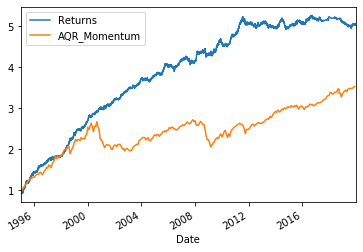

In [146]:


# convert_to_price(backtest_excess_return_series, log=True).plot()
# convert_to_price(returns_with_transcost, log=True).plot()
# convert_to_price(excess_returns_with_transcost, log=True).plot()

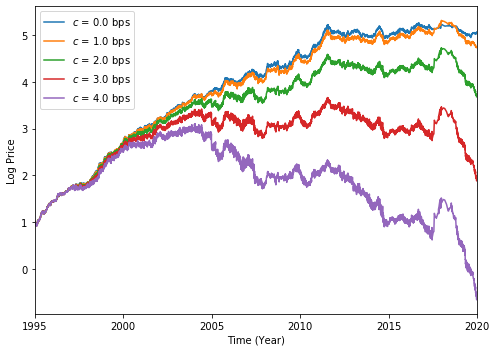

In [288]:
fig, ax = plt.subplots(figsize=(7,5))
total_turnover = 0
# convert_to_price(backtest_return_series, np.exp(1), log=True).plot(label='c = 0')
transcost_backtest_results = {}
for asset, asset_turnover in turnover_by_asset.items():
    total_turnover += ((0.15 * asset_turnover / (vola_strat * num_assets)).diff())
for transcost in [0.0, 0.001, 0.002, 0.003, 0.004]:
    total_turn_over_cost = transcost * total_turnover
    returns_with_transcost = backtest_return_series - total_turn_over_cost
    excess_returns_with_transcost = backtest_excess_return_series - total_turn_over_cost
    returns_with_transcost.dropna(inplace=True)
    convert_to_price(returns_with_transcost, np.exp(1), log=True).plot(label='$c$ = {} bps'.format(1000 * transcost))
    transcost_backtest_results[transcost] = calc_strategy_returns_stats(returns_with_transcost, excess_returns_with_transcost)
transcost_backtest_results[0] = calc_strategy_returns_stats(backtest_return_series, backtest_excess_return_series)
plt.legend()
plt.ylabel('Log Price')
plt.xlabel('Time (Year)')
plt.xticks(rotation=0, ha='center')
plt.xlim('1995-1-1', '1-1-2020')
ax.xaxis.set_major_locator(mdates.YearLocator(5, 1, 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.savefig('../plots/trans_cost_log_series.png', dpi=350)
plt.show()

In [170]:
pd.DataFrame(transcost_backtest_results).T

,E[Return],E[Excess Return],Std[Return],Skew[Return],Exc.Kurtosis[Return],Sharpe,Max_Drawdown,Max_Drawdown_Duration (Years)
0.000,0.187083,0.158849,0.145253,-0.042889,1.559649,1.093602,-0.269416,4.995885
0.001,0.171148,0.143290,0.204399,-0.333596,1.081890,0.701031,-0.442694,4.930041
0.002,0.120142,0.093490,0.352328,-0.297651,1.609002,0.265348,-0.651326,5.930041
0.003,0.038483,0.013762,0.517848,-0.215194,1.854819,0.026574,-0.831871,7.271605
0.004,-0.067024,-0.089250,0.688385,-0.161525,1.953373,-0.129651,-0.976880,14.732510


In [218]:
import matplotlib.dates as mdates

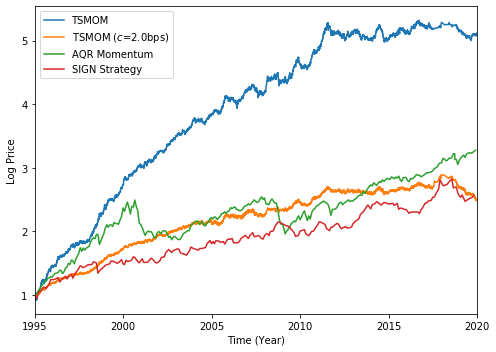

In [292]:
fig, ax = plt.subplots(figsize=(7,5))
transcost = 0.002
total_turn_over_cost = transcost * total_turnover
returns_with_transcost = backtest_return_series - total_turn_over_cost
excess_returns_with_transcost = backtest_excess_return_series - total_turn_over_cost
returns_with_transcost.dropna(inplace=True)
convert_to_price(0.15 * backtest_return_series / (np.sqrt(252) * backtest_return_series.std()), log=True).plot(label='TSMOM')
convert_to_price(0.15 * returns_with_transcost / (np.sqrt(252) * returns_with_transcost.std()), np.exp(1), log=True).plot(label='TSMOM ($c$={}bps)'.format(1000 * transcost))
convert_to_price(0.15 * aqr / (np.sqrt(12) * aqr.std()), log=True).plot(label='AQR Momentum')
convert_to_price(0.15 * sign_returns / (np.sqrt(12) * sign_returns.std()), log=True).plot(label='SIGN Strategy')

plt.ylabel('Log Price')
plt.legend()
plt.xlabel('Time (Year)')
plt.xticks(rotation=0, ha='center')
plt.xlim('1995-1-1', '1-1-2020')
ax.xaxis.set_major_locator(mdates.YearLocator(5, 1, 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.savefig('../plots/comparison_price_log_series.png', dpi=350)
plt.show()

In [263]:
r = backtest_return_series - 0.0003
r[r > 0] = 0
r.std() * np.sqrt(252)

0.08609960859423664

In [301]:
backtest_table = {}
backtest_table['TSMOM'] = calc_strategy_returns_stats(backtest_return_series, backtest_excess_return_series, target_return=0.08, target_vol=0.15)
backtest_table['TSMOM ({} bps t.c.)'.format(1000 * transcost)] = calc_strategy_returns_stats(returns_with_transcost, excess_returns_with_transcost, target_return=0.08, target_vol=0.15)
backtest_table['AQR Momentum'] = calc_strategy_returns_stats(aqr, aqr_excess, target_return=0.08, target_vol=0.15)
backtest_table['Sign Strategy'] = calc_strategy_returns_stats(sign_returns, sign_returns_excess, target_return=0.08, target_vol=0.15)

In [303]:
pd.DataFrame(backtest_table).to_csv('../plots/backtest_stats.csv')

In [300]:

sign_returns.std() * np.sqrt(12)

0.1377942901349319

In [ ]:
backtest_table = {}
tsmom_back = 0.15 * backtest_return_series / (np.sqrt(252) * backtest_return_series.std())
tsmom_cost_back = 0.15 * returns_with_transcost / (np.sqrt(252) * returns_with_transcost.std())
aqr_back = 0.15 * aqr / (np.sqrt(12) * aqr.std())
sign_back = 0.15 * sign_returns / (np.sqrt(12) * sign_returns.std())

backtest_table['TSMOM'] = calc_strategy_returns_stats(tsmom_back,tsmom_back - daily_short_rate, target_return=0.1)
backtest_table['TSMOM ({} bps t.c.)'.format(1000 * transcost)] = calc_strategy_returns_stats(tsmom_cost_back, tsmom_cost_back - daily_short_rate)
backtest_table['AQR Momentum'] = calc_strategy_returns_stats(aqr_back, aqr_back - daily_short_rate)
backtest_table['Sign Strategy'] = calc_strategy_returns_stats(sign_back, sign_back - daily_short_rate)